### Data exporation and visualization for Zillow data
* In this project I will work with the Zillow’s Home Value Prediction (Zestimate) which come from kaggle competation.

#### Installing Libraries and Useful Imports

In [26]:
# Installing Libraries
! pip install dfply
! pip install pandas-ply

# Useful Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import seaborn as sns
import types
import datetime as dt
import os
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use(u'fivethirtyeight')
path = '/Users/Huaqi Chen/Coding Scripts/ALY6140 assignment/final project'
os.chdir(path)
os.listdir()

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


['.ipynb_checkpoints',
 'all.zip',
 'properties_2016.csv',
 'properties_2017.csv',
 'sample_submission.csv',
 'train_2016_v2.csv',
 'train_2017.csv',
 'Untitled.ipynb',
 'zillow_data_dictionary.xlsx']

* Loading Data

In [38]:
properties = pd.read_csv('properties_2016.csv')
train = pd.read_csv('train_2016_v2.csv',parse_dates=["transactiondate"])    
sample = pd.read_csv('sample_submission.csv')
train.info()

C:\Users\Huaqi Chen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


* There are three variables in the train dataframe. The first is parcelid which means the number of unique labeling of houses. The second is logerror which means the difference between the predicted price and real price of houses. The last is  transaction time.

#### Logerror Analysis

Text(0.5,1,'mean logerror 0.0115')

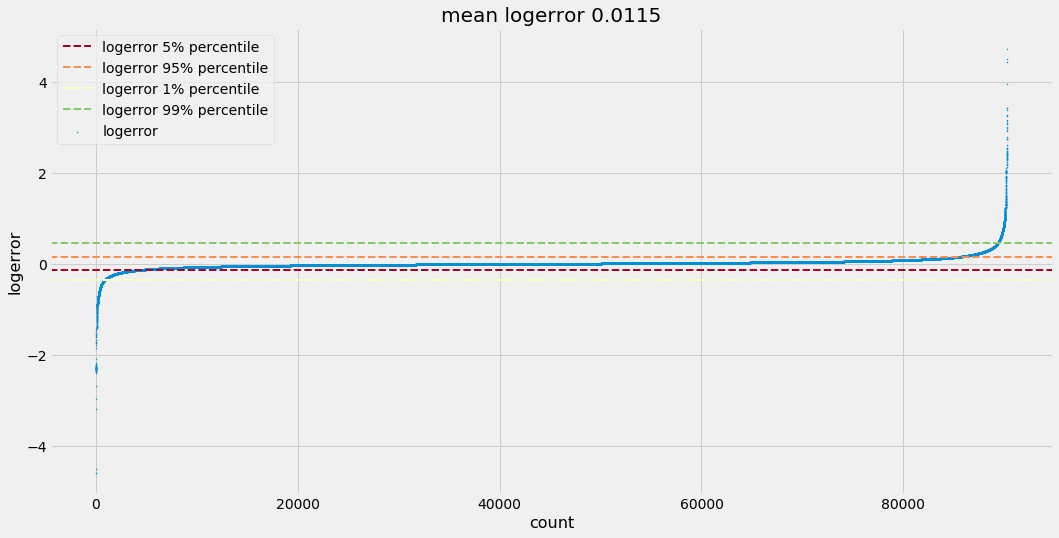

In [40]:
cm = plt.get_cmap('RdYlGn')
c = [cm(i/4) for i in range(6)]

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(range(train.shape[0]), np.sort(train.logerror.values),label='logerror', s=1)
ax.set_ylabel('logerror',size=16)
ax.set_xlabel('count',size=16)
ax.axhline(np.percentile(train.logerror, 5),linestyle='--',label='logerror 5% percentile', c=c[0], linewidth=2)
ax.axhline(np.percentile(train.logerror, 95),linestyle='--',label='logerror 95% percentile', c=c[1],linewidth=2)
ax.axhline(np.percentile(train.logerror, 1),linestyle='--',label='logerror 1% percentile', c=c[2],linewidth=2)
ax.axhline(np.percentile(train.logerror, 99),linestyle='--',label='logerror 99% percentile', c=c[3],linewidth=2)
ax.legend(fontsize=14)
ax.set_title('mean logerror %.4f'%(train.logerror.mean()), size=20)

#### Comparison between logerror distribution and normal distribution

C:\Users\Huaqi Chen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Logerror distribution and Normal distribution')

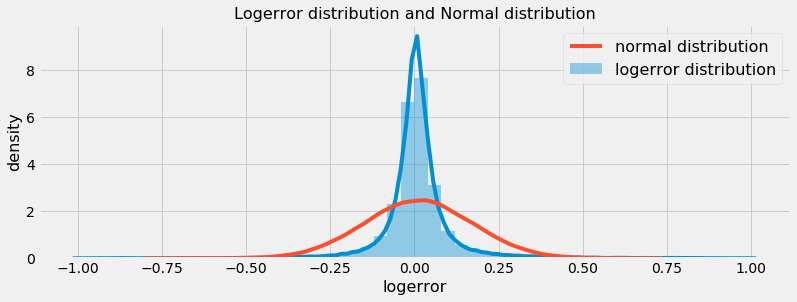

In [41]:
fig, ax = plt.subplots(figsize=(12,4))
sns.distplot(train.logerror.where((train.logerror<1)&(train.logerror>-1)).dropna(),label='logerror distribution')
sns.distplot(sp.stats.norm.rvs(sp.stats.tmean(train.logerror), 
                  sp.stats.tstd(train.logerror),
                  size=train.shape[0]), hist=False, label='normal distribution')
ax.set_xlabel('logerror', size=16)
ax.set_ylabel('density', size=16)
ax.legend(fontsize=16)
ax.set_title('Logerror distribution and Normal distribution', size=16)

#### Consistency of county and zipcode

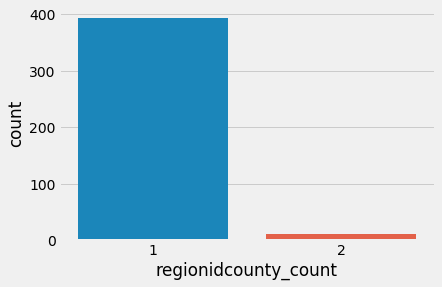

In [49]:
sns.countplot(x='regionidcounty_count',
    data=properties.groupby('regionidzip')['regionidcounty'].nunique().reset_index().rename(columns={'regionidcounty':'regionidcounty_count'}))

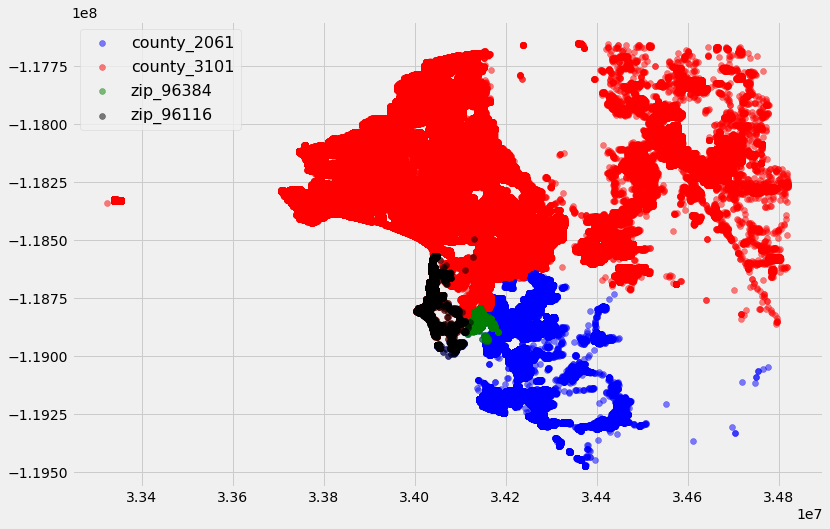

In [47]:
tmp = properties[['regionidcounty','regionidzip','latitude','longitude']].dropna().copy()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(tmp[tmp.regionidcounty==2061].latitude,tmp[tmp.regionidcounty==2061].longitude,c='b',label='county_2061',alpha=0.5)
ax.scatter(tmp[tmp.regionidcounty==3101].latitude,tmp[tmp.regionidcounty==3101].longitude,c='r',label='county_3101',alpha=0.5)
ax.scatter(tmp[tmp.regionidzip==96384].latitude,tmp[tmp.regionidzip==96384].longitude,c='g',label='zip_96384',alpha=0.5)
ax.scatter(tmp[tmp.regionidzip==96116].latitude,tmp[tmp.regionidzip==96116].longitude,c='k',label='zip_96116',alpha=0.5)

ax.legend(fontsize=16)
del tmp

* From the gragh below we can find that the zipcode and the county number does not match much

#### Detect the relationship between the city and neighborhood

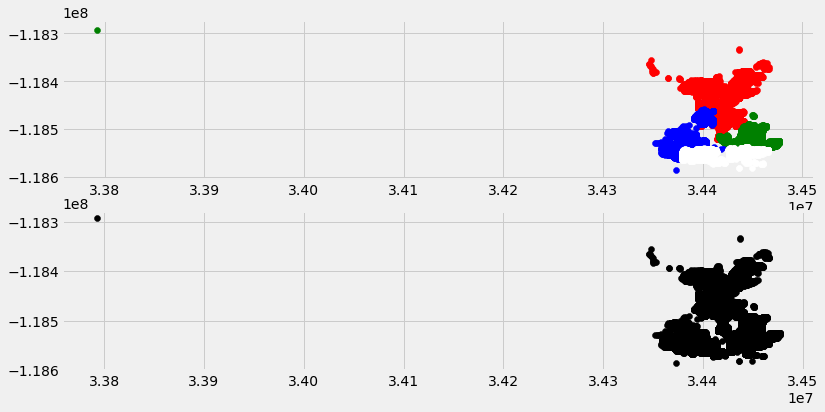

In [52]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
color = ['r','b','g','w']
x = 0
for i in properties[properties.regionidcity==54311].regionidneighborhood.unique():
    ax1.scatter(properties[properties.regionidneighborhood==i]['latitude'],properties[properties.regionidneighborhood==i]['longitude'],c=color[x])
    x+=1
ax2 = fig.add_subplot(212)
ax2.scatter(properties[properties.regionidcity==54311]['latitude'],properties[properties.regionidcity==54311]['longitude'],
            c='k',label='city 54311')

* From the gragh above we can find that the neighborhood is included in the city 

#### Detect the relationship between the city and zipcode

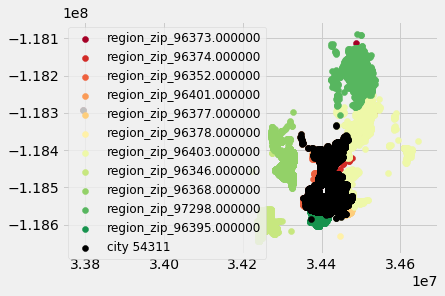

In [65]:
cm = plt.get_cmap("RdYlGn")
col = [cm(float(i)/(11)) for i in range(11)]
x=0
for i in properties[properties.regionidcity==54311].regionidzip.unique():
    #print('#%s8E90'%(str(hex(x))[1:]))
    plt.scatter(properties[properties.regionidzip==i]['latitude'],properties[properties.regionidzip==i]['longitude'],
            c=col[x],label='region_zip_%f'%(i))
    x+=1
plt.scatter(properties[properties.regionidcity==54311]['latitude'],properties[properties.regionidcity==54311]['longitude'],
            c='k',label='city 54311')
plt.legend(fontsize=12)

* from the gragh we can find that there are no consistency between the city number and zipcode

#### Feature Engineering 

In [29]:
    # error in calculation of the finished living area of home
    properties['N-LivingAreaError'] = properties['calculatedfinishedsquarefeet'] / properties['finishedsquarefeet12']
    print(properties['N-LivingAreaError'].describe())
    
    # proportion of living area
    properties['N-LivingAreaProp'] = properties['calculatedfinishedsquarefeet'] / properties['lotsizesquarefeet']
    properties['N-LivingAreaProp2'] = properties['finishedsquarefeet12'] / properties['finishedsquarefeet15']
    print(properties['N-LivingAreaProp'].describe())
    print(properties['N-LivingAreaProp2'].describe())
    
    # Total number of rooms
    properties['N-TotalRooms'] = properties['bathroomcnt'] + properties['bedroomcnt']
    print(properties['N-TotalRooms'].describe())
    
    # Average room size
    properties['N-AvRoomSize'] = properties['calculatedfinishedsquarefeet'] / properties['roomcnt']
    properties["N-location-2"] = properties["latitude"] * properties["longitude"]
    print(properties['N-AvRoomSize'].describe())
    print(properties['N-location-2'].describe())
    
    # Ratio of tax of property over parcel
    properties['N-ValueRatio'] = properties['taxvaluedollarcnt'] / properties['taxamount']
    print(properties['N-ValueRatio'].describe())

    # TotalTaxScore
    properties['N-TaxScore'] = properties['taxvaluedollarcnt'] * properties['taxamount']
    print(properties['N-TaxScore'].describe())   

count    2709184.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: N-LivingAreaError, dtype: float64
count    2.696258e+06
mean     2.619955e-01
std      2.242690e-01
min      5.127285e-06
25%      1.610368e-01
50%      2.246050e-01
75%      3.157895e-01
max      1.374173e+02
Name: N-LivingAreaProp, dtype: float64
count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: N-LivingAreaProp2, dtype: float64
count    2.973755e+06
mean     5.298080e+00
std      2.171950e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      4.000000e+01
Name: N-TotalRooms, dtype: float64


C:\Users\Huaqi Chen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


count    2.929629e+06
mean              inf
std               NaN
min      1.509677e+01
25%               NaN
50%               NaN
75%               NaN
max               inf
Name: N-AvRoomSize, dtype: float64
count    2.973780e+06
mean    -4.019088e+15
std      3.683497e+13
min     -4.142340e+15
25%     -4.044320e+15
50%     -4.017608e+15
75%     -3.994112e+15
max     -3.926421e+15
Name: N-location-2, dtype: float64
count    2.930065e+06
mean     7.789699e+01
std      1.162446e+02
min      2.984958e-04
25%      7.093460e+01
50%      7.880047e+01
75%      8.335002e+01
max      1.053556e+05
Name: N-ValueRatio, dtype: float64
count    2.930065e+06
mean     8.503903e+09
std      8.864599e+11
min      1.340000e+01
25%      4.572044e+08
50%      1.226294e+09
75%      2.999161e+09
max      9.781175e+14
Name: N-TaxScore, dtype: float64


* After finishing the feature engineering, I can make the train and test dataframe to build a model. I want to use a two-layer model fusion. Level 1 used XGBoost, LightGBM, RandomForest, ExtraTrees, DecisionTree and AdaBoost. And Level 2 used LinearRegression to fit the results of the first layer. I was trying to write some codes to do that, but the codes is not work. I thought there should be some problems happened in merging the data. I had no time to debug it. So I just paste my code as additional parts for the future study and practice. IF you have any advice, please let me know. Thank you!

class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(KFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                y_holdout = y[test_idx]
                print ("Fit Model %d fold %d" % (i, j))
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_holdout)[:]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]
            S_test[:, i] = S_test_i.mean(axis=1)

        # results = cross_val_score(self.stacker, S_train, y, cv=5, scoring='r2')
        # print("Stacker score: %.4f (%.4f)" % (results.mean(), results.std()))
        # exit()

        self.stacker.fit(S_train, y)
        res = self.stacker.predict(S_test)[:]
        return res

* rf params

rf_params = {}
rf_params['n_estimators'] = 50
rf_params['max_depth'] = 8
rf_params['min_samples_split'] = 100
rf_params['min_samples_leaf'] = 30

* xgb params

xgb_params = {}
xgb_params['n_estimators'] = 50
xgb_params['min_child_weight'] = 12
xgb_params['learning_rate'] = 0.27
xgb_params['max_depth'] = 6
xgb_params['subsample'] = 0.77
xgb_params['reg_lambda'] = 0.8
xgb_params['reg_alpha'] = 0.4
xgb_params['base_score'] = 0
xgb_params['seed'] = 400
xgb_params['silent'] = 1


* lgb params

lgb_params = {}
lgb_params['n_estimators'] = 50
lgb_params['max_bin'] = 10
lgb_params['learning_rate'] = 0.321 # shrinkage_rate
lgb_params['metric'] = 'l1'          # or 'mae'
lgb_params['sub_feature'] = 0.34    
lgb_params['bagging_fraction'] = 0.85 # sub_row
lgb_params['bagging_freq'] = 40
lgb_params['num_leaves'] = 512        # num_leaf
lgb_params['min_data'] = 500         # min_data_in_leaf
lgb_params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
lgb_params['verbose'] = 0
lgb_params['feature_fraction_seed'] = 2
lgb_params['bagging_seed'] = 3


* XGB model

xgb_model = XGBRegressor(**xgb_params)

* lgb model

lgb_model = LGBMRegressor(**lgb_params)

* RF model

rf_model = RandomForestRegressor(**rf_params)

* ET model

et_model = ExtraTreesRegressor()

* SVR model

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.05)

* DecsionTree model

dt_model = DecisionTreeRegressor()

* AdaBoost model

ada_model = AdaBoostRegressor()

stack = Ensemble(n_splits=5,
        stacker=LinearRegression(),
        base_models=(rf_model, xgb_model, lgb_model, et_model, ada_model, dt_model))

y_test = stack.fit_predict(x_train, y_train, x_test)